# Boston Housing Dataset

Analysis of the Boston Housing Dataset.

In [1]:
%pylab inline
pylab.style.use('ggplot')
import pandas as pd
import numpy as np
import seaborn as sns

Populating the interactive namespace from numpy and matplotlib


# Getting the Data

The easiest way to get thee data is to use the `sklearn.datasets.load_boston` function.

In [2]:
from sklearn.datasets import load_boston

boston_data = load_boston()

In [3]:
dir(boston_data)

['DESCR', 'data', 'feature_names', 'target']

In [4]:
data_df = pd.DataFrame(boston_data.data, columns=boston_data.feature_names)

In [5]:
data_df = data_df.assign(target=boston_data.target)

In [6]:
data_df.head()

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,target
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


# Univariate Analysis

In [7]:
data_df.shape[1]

14

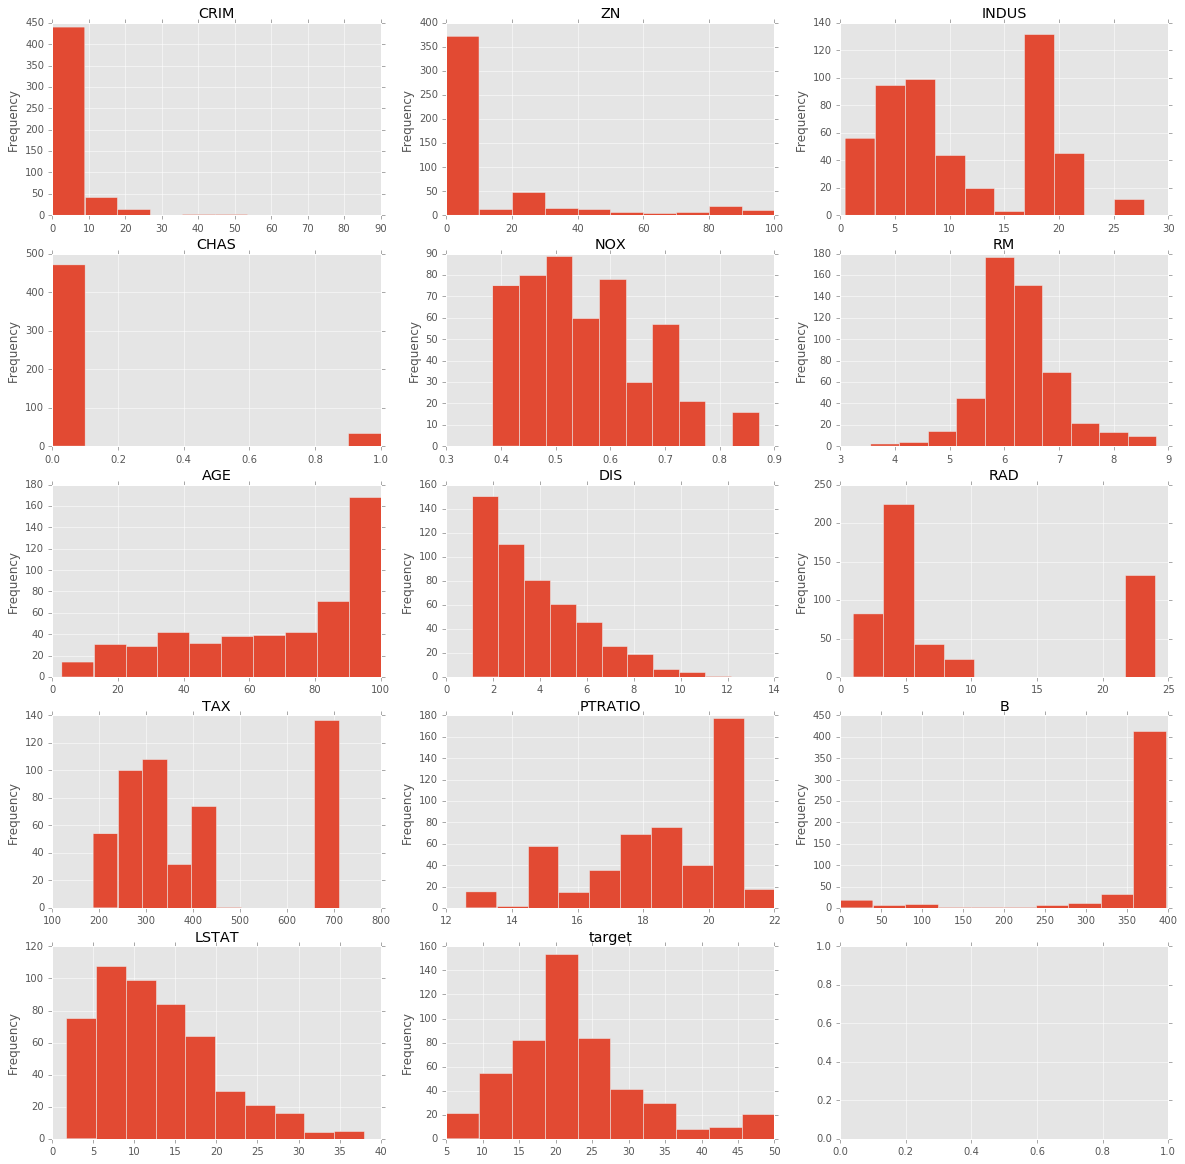

In [8]:
_, axes = pylab.subplots(5, 3, figsize=(20, 20))

for idx, colname in enumerate(data_df.columns):
    row, col = divmod(idx, 3)
    data_df.loc[:, colname].plot(kind='hist', ax=axes[row][col], title=colname)

# Bivariate Analysis

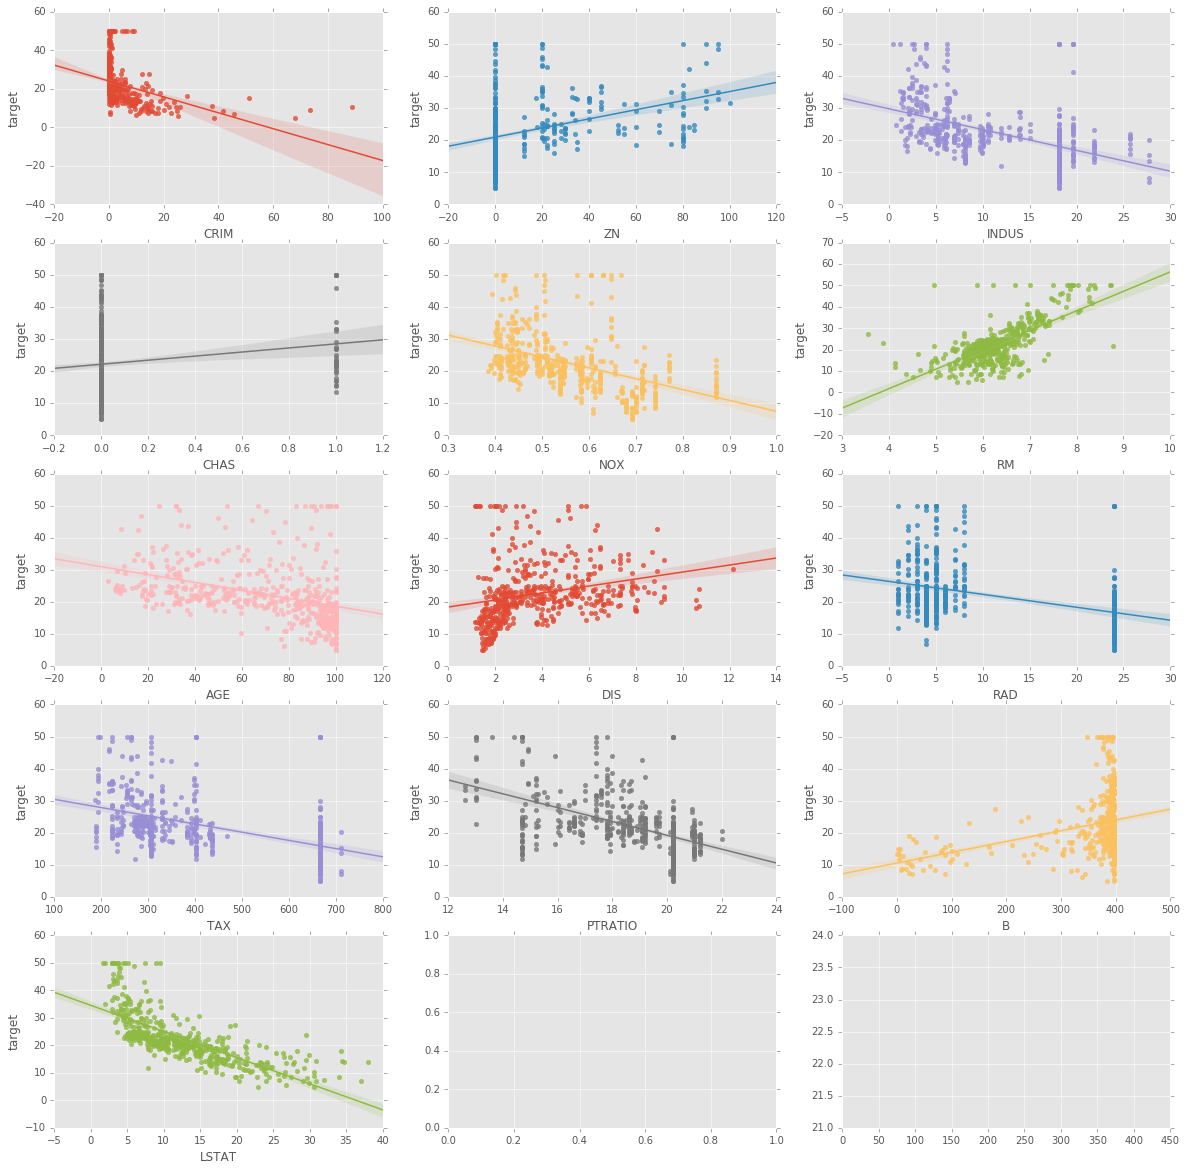

In [9]:
_, axes = pylab.subplots(5, 3, figsize=(20, 20))

for idx, colname in enumerate(data_df.columns.drop('target')):    
    row, col = divmod(idx, 3)
    sns.regplot(data=data_df, x=colname, y='target', ax=axes[row][col])

# Feature Correlations

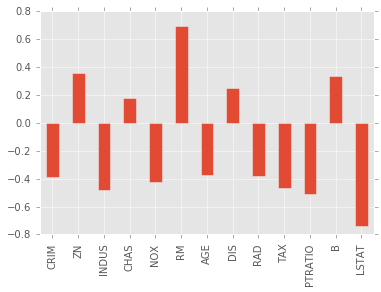

In [10]:
f_corrs = data_df.drop('target', axis=1).corrwith(data_df.target)
f_corrs.plot(kind='bar')

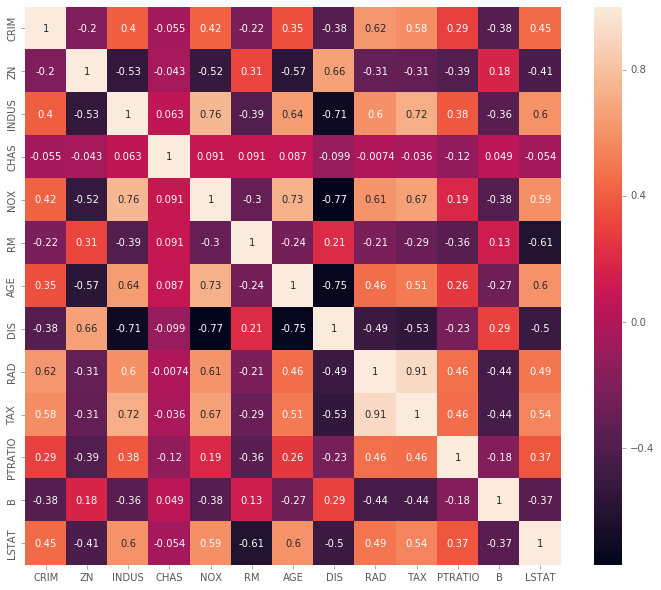

In [11]:
_, ax = pylab.subplots(1, 1, figsize=(12, 10))
corrs = data_df.drop('target', axis=1).corr()
sns.heatmap(corrs, annot=True, ax=ax)

# Feature Importances

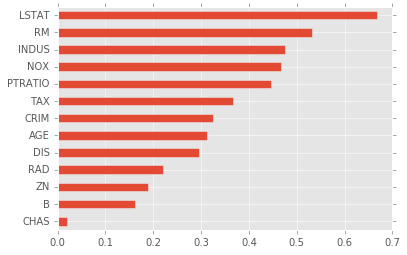

In [12]:
from sklearn.feature_selection import mutual_info_regression

importances = mutual_info_regression(data_df.drop('target', axis=1), data_df.target)
importances = pd.Series(data=importances, index=data_df.columns.drop('target').copy())

importances.sort_values(ascending=True).plot(kind='barh')

# Random Forest Regressor

In [13]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold

In [14]:
def score_with_best_k_features(k):
    """Cross_val score with best n features."""

    model = RandomForestRegressor(n_estimators=50, max_features=k)
    features = data_df.drop('target', axis=1)
    target = data_df.target

    cv = KFold(n_splits=10, shuffle=True, random_state=1234) 

    scores = cross_val_score(estimator=model, 
                             X=features, 
                             y=target, 
                             cv=cv,
                             scoring='r2')

    scores = pd.Series(scores)    
    return scores

In [15]:
scores = {k: score_with_best_k_features(k) for k in (5, 9, 13)}
scores = pd.concat(scores, axis=1)

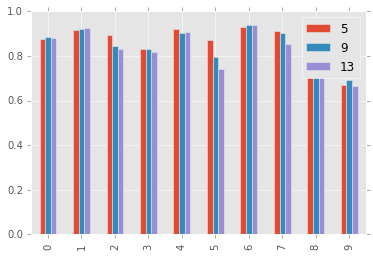

In [16]:
scores.plot(kind='bar')

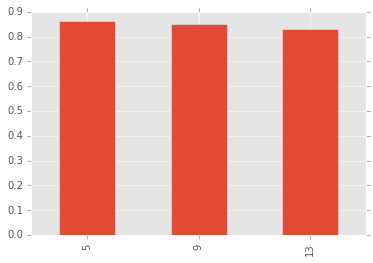

In [17]:
scores.mean().plot(kind='bar')

In [18]:
scores.T

,0,1,2,3,4,5,6,7,8,9
5,0.874687,0.915860,0.891514,0.829263,0.920731,0.872104,0.930854,0.910429,0.815378,0.671340
9,0.882683,0.921308,0.843245,0.832220,0.902560,0.794787,0.938194,0.903834,0.792211,0.693847
13,0.882219,0.923986,0.830504,0.818592,0.905698,0.740840,0.937183,0.853072,0.764192,0.664189


In [19]:
scores.mean()

5     0.863216
9     0.850489
13    0.832048
dtype: float64

# HyperParamater Tuning with GridSearch

In [20]:
from sklearn.model_selection import GridSearchCV

In [21]:
model = RandomForestRegressor()

param_grid = {
    'n_estimators' : [100, 120, 140, 160, 180, 200],
    'max_depth'    : [10],
    'max_features' : [5],    
}

cv = KFold(n_splits=10, shuffle=True, random_state=1234) 

grid_search = GridSearchCV(model, param_grid, cv=cv, verbose=1)

features = data_df.drop('target', axis=1)
target = data_df.target

grid_search = grid_search.fit(X=features, y=target)

Fitting 10 folds for each of 6 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   24.3s finished


In [22]:
grid_search.best_params_

{'max_depth': 10, 'max_features': 5, 'n_estimators': 100}

In [23]:
grid_search.best_score_

0.8699525055696834